In [31]:
'''
test of basic machine learning pipeline on uci machine learning repository

QSAR oral toxicity Data Set:
http://archive.ics.uci.edu/ml/datasets/QSAR+oral+toxicity
'''

import numpy
import pandas
import matplotlib.pyplot as plt

from mpl_toolkits.mplot3d import Axes3D

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split as tts
from sklearn.model_selection import StratifiedKFold

from sklearn.linear_model import LogisticRegression
from sklearn import tree
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier

from sklearn.metrics import plot_roc_curve
from sklearn.metrics import auc
from numpy import interp

from yellowbrick.classifier import ConfusionMatrix

**Dataset details:**

QSAR (quantitative structure activity relationship) is a drug classification scheme. The goal of this dataset is to predict how toxic molecules are based on their chemical structure.  Animal toxicity tests are expensive, machine learning is cheap!

8991 molecules have been characterized experimentally as being either highly orally toxic ('positive') or not ('negative').  1024 structural attributes have been identified from the chemical structures as either being absent (0) or present (1).  The data format is each row is a molecule, the first 1024 columns are the features present in each molecule, and the 1025th column is the binary toxicity of the molecule.

The good news is that this data is pre-wrangled and is entirely normalized.

In [7]:
qsar_dataset = pandas.read_csv('qsar_oral_toxicity.csv',delimiter=';')

print (qsar_dataset)

y = qsar_dataset['negative']
X = qsar_dataset.drop('negative',axis=1)

      0  0.1  0.2  0.3  0.4  0.5  0.6  0.7  0.8  0.9  ...  0.962  0.963  \
0     0    0    1    0    0    0    0    0    0    0  ...      0      0   
1     0    0    0    0    0    0    0    0    0    0  ...      0      0   
2     0    0    0    0    0    0    0    1    0    0  ...      0      0   
3     0    0    0    0    0    0    0    0    0    0  ...      0      0   
4     1    0    0    0    0    0    1    0    0    0  ...      0      0   
...  ..  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...    ...    ...   
8986  0    0    0    0    0    0    0    1    0    0  ...      0      0   
8987  0    1    0    0    0    1    0    1    0    0  ...      0      0   
8988  0    0    0    0    0    0    0    1    0    0  ...      0      0   
8989  0    0    0    0    0    0    0    0    0    0  ...      0      0   
8990  0    0    1    0    0    0    0    0    0    0  ...      1      0   

      0.964  0.965  0.966  0.967  0.968  0.969  0.970  negative  
0         0      0      0      0 

**Step 1: PCA and Visualization**

The bad news is that visualizing the raw 1024-dimensional dataset isn't really possible.  Instead, we will use priniciple component analysis to transform the data such that we can capture as much of the variance from 1024 dimensions in the 2 or 3 highest dimensions, which can be plotted on a 2d screen.

explained variance ratio (first two components): [0.1017389  0.06776901]


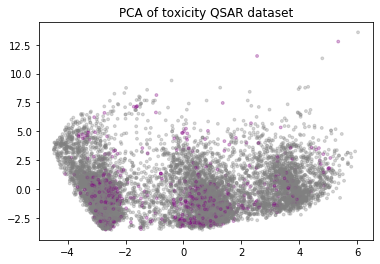

In [4]:
pca = PCA(n_components=2)
X_r = pca.fit(X).transform(X)

#split each component out of the tuple to graph
X_r1,X_r2 = [list(c) for c in zip(*X_r)]

print('explained variance ratio (first two components): %s'
      % str(pca.explained_variance_ratio_))
graph_colors = list(map(lambda x: 'grey' if x == 'negative' else 'purple',y))
plt.scatter(X_r1,X_r2,s=8,color=graph_colors,alpha=.3)
#plt.hexbin(X_r1, X_r2, gridsize=(50,50) )

plt.title('PCA of toxicity QSAR dataset')
plt.show()

explained variance ratio (first three components): [0.1017389  0.06776901 0.03298615]


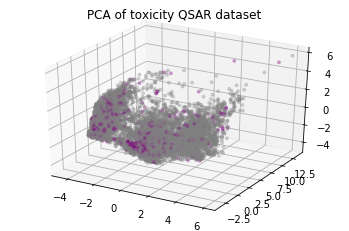

In [111]:
pca = PCA(n_components=3)
X_r = pca.fit(X).transform(X)

#split each component out of the tuple to graph
X_r1,X_r2,X_r3 = [list(c) for c in zip(*X_r)]

print('explained variance ratio (first three components): %s'
      % str(pca.explained_variance_ratio_))
graph_colors = list(map(lambda x: 'grey' if x == 'negative' else 'purple',y))
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_r1,X_r2,X_r3,s=8,color=graph_colors,alpha=.3)
#plt.hexbin(X_r1, X_r2, gridsize=(50,50) )

plt.title('PCA of toxicity QSAR dataset')
plt.show()

There are definitely clusters of similar structures in this space, but there is no good separation between toxic (purple) and non-toxic (grey) in this space.

We could try using ML on a subset of the PCA components.  Reducing the dimensionality of the problem is a good way to make it more managable (at the cost of losing some of the original data, of course).

The question then becomes how many components do we need to perserve most of the data?

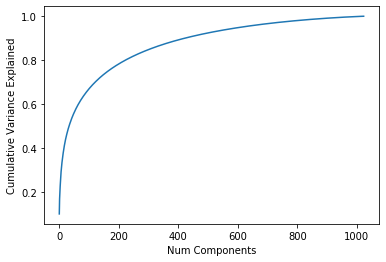

In [88]:
#i know this is wasteful, but it makes the graph look good
pca = PCA(n_components=1024)
X_r = pca.fit(X).transform(X)

total_variance = numpy.cumsum(pca.explained_variance_ratio_)

plt.plot(total_variance)
plt.xlabel('Num Components')
plt.ylabel('Cumulative Variance Explained')
plt.show()

Unfortunately, it looks like the data is still very multidimensional. We'll generate an alternate feature vector from the first 100 components, capturing around 70% of the variance in 10x fewer dimensions, and fit both to see which works better.

**Step 2: Split the data into training and test sets, and choose machine learning models.**

We do a 50%, 50% split between training and test sets, with 12x cross-validation (eventually). 

In [8]:
#save the appropriate PCA data for use
pca = PCA(n_components=100)
X_pca = pca.fit(X).transform(X)

#convert y values to integers
y_int = list(map(lambda x: 0 if x == 'negative' else 1,y))

#split the data and pca data into training and test sets
X_train, X_test, y_train, y_test = tts(X,y_int,test_size=0.5,shuffle=True)
X_train_pca, X_test_pca, y_train_pca, y_test_pca = tts(X_pca,y_int,test_size=0.5,shuffle=True)

Models we're going to use:
* Logistic Regression (with elastic net constraints)
* Naive Bayes
* Decision Trees
* Support Vector Machines

In [38]:
#logistic regression
log_model = LogisticRegression(max_iter=500)
log_model.fit(X_train,y_train)
log1 = log_model.score(X_test,y_test)

log_model2 = LogisticRegression(max_iter=500)
log_model2.fit(X_train_pca,y_train_pca)
log2 = log_model2.score(X_test_pca,y_test_pca)

print (log1, log2)

0.923932384341637 0.923932384341637


In [39]:
#gaussian naive bayes
nb_model = GaussianNB()
nb_model.fit(X_train,y_train)
nb1 = nb_model.score(X_test,y_test)

nb_model2 = GaussianNB()
nb_model2.fit(X_train_pca,y_train_pca)
nb2 = nb_model2.score(X_test_pca,y_test_pca)

print (nb1, nb2)

0.7066281138790036 0.9096975088967971


In [40]:
#decision trees
tree_model = tree.DecisionTreeClassifier()
tree_model.fit(X_train,y_train)
tree1 = tree_model.score(X_test,y_test)

tree_model2 = tree.DecisionTreeClassifier()
tree_model2.fit(X_train_pca,y_train_pca)
tree2 = tree_model2.score(X_test_pca,y_test_pca)
print (tree1, tree2)

0.900355871886121 0.8774466192170819


In [41]:
#random forest trees
forest_model = RandomForestClassifier()
forest_model.fit(X_train,y_train)
forest1 = forest_model.score(X_test,y_test)

print (tree1)

0.900355871886121


In [42]:
#svm
svc_model = svm.SVC()
svc_model.fit(X_train,y_train)
svc1 = svc_model.score(X_test,y_test)

svc_model2 = svm.SVC()
svc_model2.fit(X_train_pca,y_train_pca)
svc2 = svc_model2.score(X_test_pca,y_test_pca)

print (svc1, svc2)

0.9359430604982206 0.9326067615658363


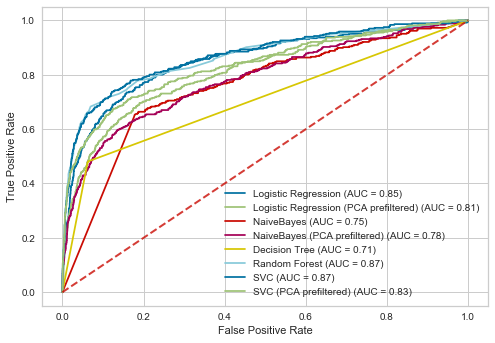

In [43]:
#set up axis for graphing
plt.clf()
ax = plt.gca()

logreg1_disp = plot_roc_curve(log_model, X_test, y_test,ax=ax,name='Logistic Regression')
logreg2_disp = plot_roc_curve(log_model2, X_test_pca, y_test_pca,ax=ax,name='Logistic Regression (PCA prefiltered)')
logreg1_disp = plot_roc_curve(nb_model, X_test, y_test,ax=ax,name='NaiveBayes')
logreg2_disp = plot_roc_curve(nb_model2, X_test_pca, y_test_pca,ax=ax,name='NaiveBayes (PCA prefiltered)')
logreg1_disp = plot_roc_curve(tree_model, X_test, y_test,ax=ax,name='Decision Tree')
logreg1_disp = plot_roc_curve(forest_model, X_test, y_test,ax=ax,name='Random Forest')
logreg1_disp = plot_roc_curve(svc_model, X_test, y_test,ax=ax,name='SVC')
logreg2_disp = plot_roc_curve(svc_model2, X_test_pca, y_test_pca,ax=ax,name='SVC (PCA prefiltered)')

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)
plt.show()

**Preliminary results**

SVM and Logistic regression seem to be performing well, and the truncated PCA transformation slightly hurts the logistic regression and doesn't effect the SVM model at all. The prefiltering appears to actually improve Naive Bayes's ability to fit.   Decision trees are decidedly inferior to both.

We should look at confusion matrices (especially the number of false negatives, which in this case leads to people getting poisoned!)

TODO: 
* hyperparameter tuning
* random forest
* minimize models with a different score that weights False Negatives much higher
* some sort of visualization (clustering would probably be best)

Below is the cross-validation for logistic regression, as an estimate of error for comparing models.

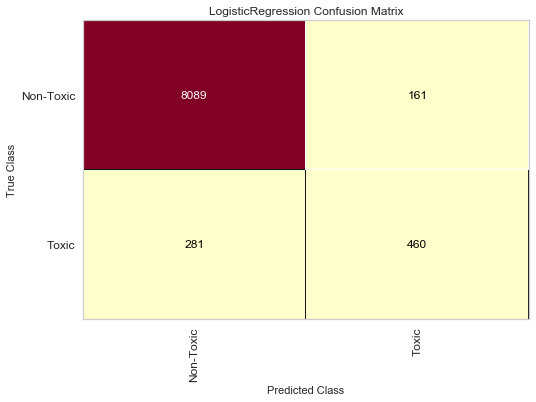

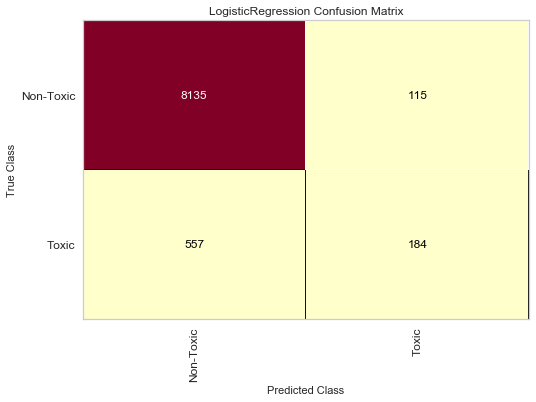

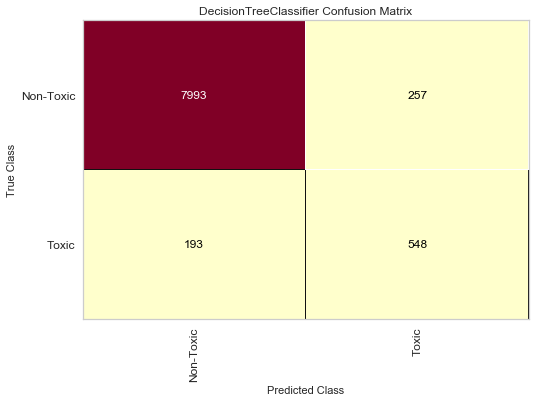

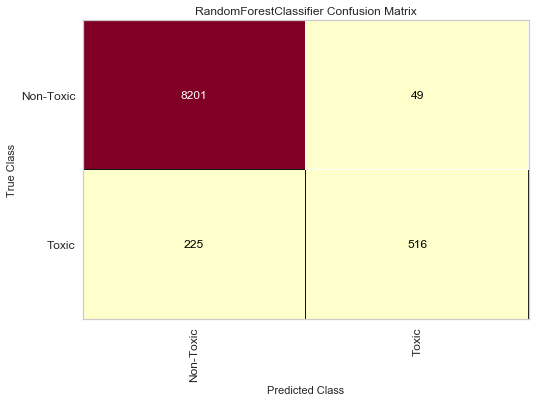

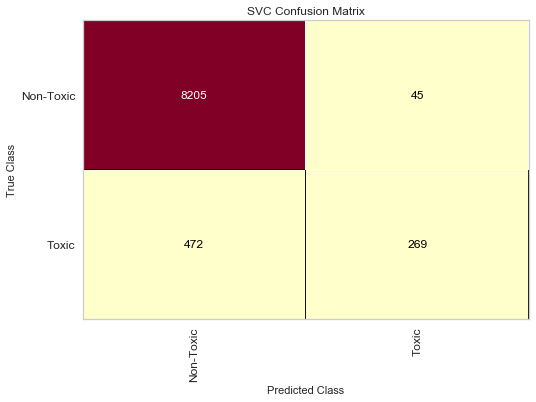

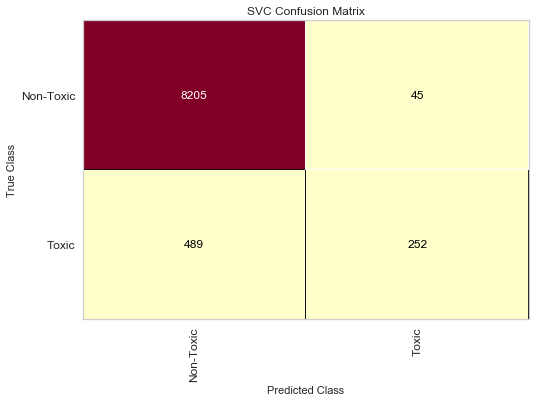

In [44]:
#yellowbrick loves spitting out warnings, this squelches them
import warnings; warnings.simplefilter('ignore')

cm = ConfusionMatrix(log_model, classes=['Non-Toxic','Toxic'])
cm.score(X, y_int)
cm.show()

cm = ConfusionMatrix(log_model2, classes=['Non-Toxic','Toxic'])
cm.score(X_pca, y_int)
cm.show()

cm = ConfusionMatrix(tree_model, classes=['Non-Toxic','Toxic'])
cm.score(X, y_int)
cm.show()

cm = ConfusionMatrix(forest_model, classes=['Non-Toxic','Toxic'])
cm.score(X, y_int)
cm.show()

cm = ConfusionMatrix(svc_model, classes=['Non-Toxic','Toxic'])
cm.score(X, y_int)
cm.show()

cm = ConfusionMatrix(svc_model2, classes=['Non-Toxic','Toxic'])
cm.score(X_pca, y_int)
cm.show()

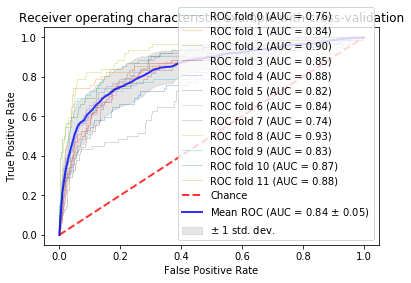

In [12]:
#cross validation (for logistic regression, 5x the svm training time is very long)

cv = StratifiedKFold(n_splits=12)
classifier = LogisticRegression(max_iter=500)

tprs = []
aucs = []
mean_fpr = numpy.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train_index, test_index) in enumerate(cv.split(X, y)):
    X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
    y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]
    
    classifier.fit(X_train_cv, y_train_cv)
    viz = plot_roc_curve(classifier, X_test_cv, y_test_cv,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = numpy.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = numpy.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = numpy.std(tprs, axis=0)
tprs_upper = numpy.minimum(mean_tpr + std_tpr, 1)
tprs_lower = numpy.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic example with cross-validation")
ax.legend(loc="lower right")
plt.show()

In [119]:
print (svc_model)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


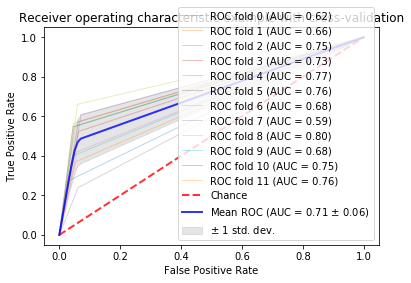

In [13]:
#cross validation (for decision trees)

cv = StratifiedKFold(n_splits=12)
classifier = tree.DecisionTreeClassifier()
tprs = []
aucs = []
mean_fpr = numpy.linspace(0, 1, 100)

fig, ax = plt.subplots()
for i, (train_index, test_index) in enumerate(cv.split(X, y)):
    X_train_cv, X_test_cv = X.iloc[train_index], X.iloc[test_index]
    y_train_cv, y_test_cv = y.iloc[train_index], y.iloc[test_index]
    
    classifier.fit(X_train_cv, y_train_cv)
    viz = plot_roc_curve(classifier, X_test_cv, y_test_cv,
                         name='ROC fold {}'.format(i),
                         alpha=0.3, lw=1, ax=ax)
    interp_tpr = interp(mean_fpr, viz.fpr, viz.tpr)
    interp_tpr[0] = 0.0
    tprs.append(interp_tpr)
    aucs.append(viz.roc_auc)

ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='r',
        label='Chance', alpha=.8)

mean_tpr = numpy.mean(tprs, axis=0)
mean_tpr[-1] = 1.0
mean_auc = auc(mean_fpr, mean_tpr)
std_auc = numpy.std(aucs)
ax.plot(mean_fpr, mean_tpr, color='b',
        label=r'Mean ROC (AUC = %0.2f $\pm$ %0.2f)' % (mean_auc, std_auc),
        lw=2, alpha=.8)

std_tpr = numpy.std(tprs, axis=0)
tprs_upper = numpy.minimum(mean_tpr + std_tpr, 1)
tprs_lower = numpy.maximum(mean_tpr - std_tpr, 0)
ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color='grey', alpha=.2,
                label=r'$\pm$ 1 std. dev.')

ax.set(xlim=[-0.05, 1.05], ylim=[-0.05, 1.05],
       title="Receiver operating characteristic example with cross-validation")
ax.legend(loc="lower right")
plt.show()